# Assignment 5

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

__Solution 1.1.__

In [1]:
#setup
import numpy as np
import pandas as pd
import requests
import requests_cache
import seaborn as sb
import matplotlib.pyplot as plt
import nltk

from nltk import corpus
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer
from bs4 import BeautifulSoup as bsoup
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
requests_cache.install_cache("aggie_cache")

In [2]:
def extract_article_link(url_link, page_num = 1, art_links = None):
    """
    Extract article urls from a given url page
    
    Arguments:
        url_link : the url page to extract from
        page_num : up to how many pages to extract(default to 1)
        art_links: list to store links
    
    Return:
        list of article links
    """
    #detect error
    try:
        url_rsp = requests.get(url_link)
    except:
        requests.get(url_link).raise_for_status()
    #make a list to store article links, prevent from reinitializing during recursion   
    if art_links == None:
        art_links = []
           
    #page content in unicode
    page_soup = bsoup(url_rsp.text, 'html.parser')

    #next page url
    next_page = page_soup.find_all('a', class_ ='page-numbers')
    next_page_url = next_page[-1].get('href')        
    
    #get all the h2 tags in the html page
    h2_all = page_soup.find_all("h2", class_="entry-title")
        
    #get all the link in with a tags and append it to the list
    for i in xrange(len(h2_all)):
        art_links.append(h2_all[i].a.get('href'))
    #if only want 1 page of urls, return the list    
    if int(page_num) == 1:
        return art_links
    #else recursively calling the function until url_page is 1
    else:
        return extract_article_link(next_page_url, page_num -1, art_links)
    #return art_links

In [3]:
#demo in campus news sections
extract_article_link("https://theaggie.org/campus")[:6]

[u'https://theaggie.org/2017/02/21/uc-president-selects-gary-may-as-new-uc-davis-chancellor/',
 u'https://theaggie.org/2017/02/20/katehi-controversy-prompts-decline-of-uc-administrators-seeking-profitable-subsidiary-board-positions/',
 u'https://theaggie.org/2017/02/20/asucd-senate-passes-resolution-submitting-comments-on-lrdp/',
 u'https://theaggie.org/2017/02/20/uc-releases-2016-annual-report-on-sustainable-practices/',
 u'https://theaggie.org/2017/02/19/uc-davis-global-affairs-holds-discussion-on-president-donald-trumps-executive-orders-on-immigration/',
 u'https://theaggie.org/2017/02/19/trumps-immigration-ban-affects-uc-davis-community/']

In [4]:
#demo in art section
extract_article_link("https://theaggie.org/arts")[:6]

[u'https://theaggie.org/2017/02/20/student-sounds-samantha-sipin/',
 u'https://theaggie.org/2017/02/20/tv-revisited-the-office/',
 u'https://theaggie.org/2017/02/19/uc-davis-theater-and-dance-presents-its-newest-comedy/',
 u'https://theaggie.org/2017/02/19/twenty-one-pilots-emotional-roadshow-world-tour/',
 u'https://theaggie.org/2017/02/16/a-night-under-the-stars/',
 u'https://theaggie.org/2017/02/14/critically-acclaimed-stand-up-comic-brian-regan-to-perform-at-mondavi-center/']

<hr style="height:2px;border:none;color:#333;" />

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

*   Python 2 displays some Unicode characters as `\uXXXX`. For instance, `\u201c` is a left-facing quotation mark.
    You can convert most of these to ASCII characters with the method call (on a string)
    ```
    .translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    ```
    If you're curious about these characters, you can look them up on [this page](http://unicode.org/cldr/utility/character.jsp), or read 
    more about [what Unicode is](http://unicode.org/standard/WhatIsUnicode.html).

__Solution 1.2.__

In [5]:
def extract_article_info(art_url):
    """
    Extract article urls from a given url page
    
    Arguments:
        url_link : the url page to extract from
        page_num : up to how many pages to extract(default to 1)
        art_links: list to store links
    
    Return:
        list of article links
    """
    #for translate unicode
    code = { 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 }
    #dictionary to store all values
    art_dict = {}
    
    #article url
    art_dict['url'] = art_url

    art_resp = requests.get(art_url)
    #article content in unicode
    art_soup = bsoup(art_resp.text, 'lxml')
    #title of the article
    art_dict['title'] = art_soup.title.string.split('|')[0].strip().translate(code)
    
    #getting all <p> in div class called clearfix
    art_div = art_soup.find_all('div', attrs = {"class": "clearfix"})
    #loop over each div and find the correct p
    for i in art_div:
        if i.find_all('p') != []:
            art_content = i.find_all('p')
            break  
    #author of the article
    art_dict['author'] = art_content[-1].text.split('\n')[-1]
    
    #string to glue all <p> for article text
    art_str =''
    
    if art_content[0].strong != None:
        art_bold = art_content[0].strong.text.translate(code)
        for i in art_content[1:]:
            art_str += i.text.translate(code).strip()
        #filter out written by in p tags 
        if "@theaggie.org" not in art_str:
            art_dict['text'] = art_bold + ' ' + art_str.split('\n')[0]
        else:
            art_str = ''
            for i in art_content[1:-1]:
                art_str += i.text.translate(code).strip()
            art_dict['text'] = art_bold + ' ' + art_str.split('\n')[0]
            

    else:
        for i in art_content:
            art_str += i.text.translate(code).strip()+ ' '
        #text
        if "@theaggie.org" not in art_str:
            art_dict['text'] = art_str.split('\n')[0] 

        else:
            for i in art_content[:-1]:
                art_str += i.text.translate(code).strip() + ' '
        
            art_dict['text'] = art_str.split('\n')[0]
        
    return art_dict

In [6]:
#demo
demo_link = "https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/"
extract_article_info(demo_link)

{'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
 'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design.Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager."City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto ef

<hr style="height:2px;border:none;color:#333;" />

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

__Solution 1.3.__

In [7]:
def make_df(url, page_num, category):
    """
    Make a pandas dataframe with given article category, url, and number of pages 
    
    Argument: 
        URL: url of the article section to extract from(string)
        page_num: how many pages to extract in total (int)
        category: what kind of news category(string)
    
    Return: pandas df
    """
    #getting the links first
    links = extract_article_link(url,page_num)
    #make a empty list for converting to df later
    df_list = []
    for  i in links:
        df_list.append(extract_article_info(i))
        #add category
    df = pd.DataFrame(df_list)
    df["category"] = pd.Series(category, index = df.index)
    return df

In [8]:
campus_news_df = make_df("https://theaggie.org/campus/", 4, "campus news")
city_news_df =make_df("https://theaggie.org/city/", 4, "city news")
news_df = campus_news_df.append(city_news_df, ignore_index = True)

In [9]:
#demo
news_df.tail()

,author,text,title,url,category
115,Written by: Raul Castellanos — city@theaggie.org,Bernie Sanders visits Sacramento to rally for ...,Return of the Bern,https://theaggie.org/2016/11/15/return-of-the-...,city news
116,Written by: Alana Joldersma –– city@theaggie.org,"Indoor facility will provide a cafeteria, clas...",Construction of the All Student Center at Davi...,https://theaggie.org/2016/11/14/construction-o...,city news
117,Written by: Raul Castellanos – city@theaggie.org,"Davis turkeys threaten residents, students Acc...",Wild turkeys in Davis,https://theaggie.org/2016/11/13/wild-turkeys-i...,city news
118,Written by: Kaelyn Tuermer-Lee – city@theaggie...,Davis Manor neighborhood's newest street add...,Drawing the lines of community ideals,https://theaggie.org/2016/11/13/drawing-the-li...,city news
119,Written By: BIANCA ANTUNEZ – city@theaggie.org,Farmers overwhelming medical marijuana market ...,Cannabis cultivation permit problems persist,https://theaggie.org/2016/11/07/cannabis-culti...,city news


<hr style="height:2px;border:none;color:#333;" />

__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

__Solution 1.4.__

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?


### Let's first look at the word freqencies in article titles and text to get dea of topic coverage

In [10]:
#function to tokenize, lemmatize
def process_text(text):
    """
    Take text and process by tokenizing, lemmatizing 
    
    Arguments: series of text (pd series, string)
    
    Return: list of words 
    """
    tokenize = nltk.word_tokenize
    lemmatize = WordNetLemmatizer().lemmatize
    toked = []
    for i in text:
        toked.extend(tokenize(i.lower() ))
        
    lemmd = [lemmatize(x, pos = 'v') for x in toked]
    
    stop_words = set(stopwords.words('english'))
    filtered_text = filter(lambda x: x not in stop_words, lemmd)
    
    return filtered_text
    

In [11]:
#function to stem
def stem_text(text, filter_pun = False):
    """
    Stemming text documents
    
    Argument: 
        text: series/list of texts(string, pd series)
        filter_pun: boolean      
    
    Return: list of stemmed words(list, string)
    
    """
        
    stemmer = PorterStemmer().stem
    stemmed = [stemmer(i) for i in process_text(text)]
    if filter_pun == True:
        return [i for i in stemmed if i.isalpha()]
    else:
        return stemmed
    
    

In [12]:
#function to get top counts
def top_count(text, n):
    """
    Get top n word counts in a given text
    
    Arguments: 
        text: series of texts(string)
        n: top N many words (int)
    Return: 
    """
    stemming = stem_text(text)
    top_n = Counter(stemming).most_common(100)
    #filter out punctuation
    top_n = [i for i in top_n if i[0].isalpha()]
    return top_n[:n]

In [13]:
top_title_words = top_count(news_df['title'], 30)
top_title_words

[(u'davi', 39),
 (u'uc', 33),
 (u'polic', 11),
 (u'student', 11),
 (u'log', 10),
 (u'senat', 8),
 (u'event', 7),
 (u'protest', 6),
 (u'new', 6),
 (u'day', 6),
 (u'yolo', 6),
 (u'milo', 5),
 (u'trump', 5),
 (u'first', 5),
 (u'citi', 5),
 (u'yiannopoulo', 5),
 (u'tuition', 5),
 (u'counti', 4),
 (u'campaign', 4),
 (u'food', 4),
 (u'presid', 4),
 (u'light', 4),
 (u'last', 4),
 (u'week', 4),
 (u'sacramento', 4),
 (u'center', 4),
 (u'chancellor', 4),
 (u'host', 4),
 (u'health', 3),
 (u'school', 3)]

In [14]:
top_text_words = top_count(news_df['text'], 30)
top_text_words

[(u'davi', 755),
 (u'student', 573),
 (u'say', 570),
 (u'uc', 454),
 (u'commun', 310),
 (u'peopl', 238),
 (u'year', 198),
 (u'citi', 190),
 (u'campu', 187),
 (u'also', 177),
 (u'event', 176),
 (u'go', 172),
 (u'one', 158),
 (u'make', 156),
 (u'state', 149),
 (u'work', 145),
 (u'come', 143),
 (u'support', 140),
 (u'help', 137),
 (u'univers', 126),
 (u'would', 124),
 (u'provid', 123),
 (u'like', 122),
 (u'think', 121),
 (u'program', 121),
 (u'senat', 120),
 (u'want', 113),
 (u'major', 112),
 (u'california', 112),
 (u'food', 110)]

<b>Above shows 20 most common words from 120 article titles and texts based on the frequency of word counts</b>

### Visualize it with a word map

(-0.5, 399.5, 199.5, -0.5)

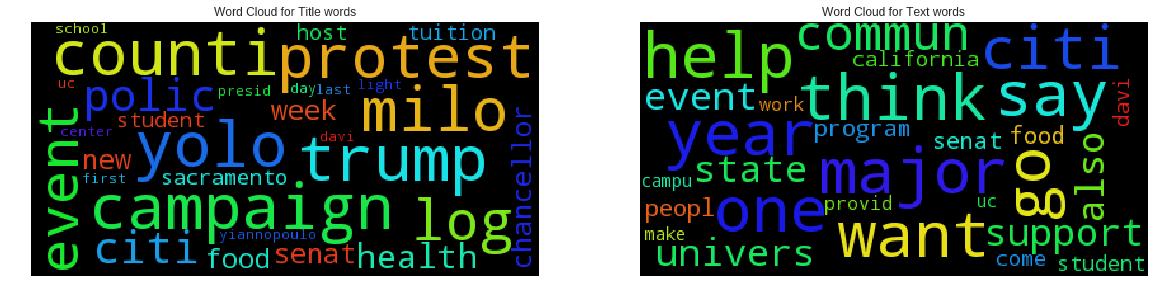

In [15]:
title_words_count = [x[0] for x in top_title_words]
text_words_count = [x[0] for x in top_text_words]

title_cloud = WordCloud(max_font_size=50).generate(' '.join(title_words_count))
text_cloud = WordCloud(max_font_size=50).generate(' '.join(text_words_count))
# Display the generated image:
# the matplotlib way:
fig, axes = plt.subplots(1, 2, figsize=(20,20))
# plt.figure(figsize = (8,4))
# plt.subplot(121)
axes[0].imshow(title_cloud)
axes[0].set_title("Word Cloud for Title words")
axes[0].axis("off")

# plt.figure(figsize = (8,4))
# plt.subplot(122)
axes[1].imshow(text_cloud)
axes[1].set_title("Word Cloud for Text words")
axes[1].axis("off")


### Visualize with Dotplot

In [16]:
title_count_df = pd.DataFrame(top_title_words, columns =["Word","Count"])
text_count_df = pd.DataFrame(top_text_words, columns =["Word","Count"])

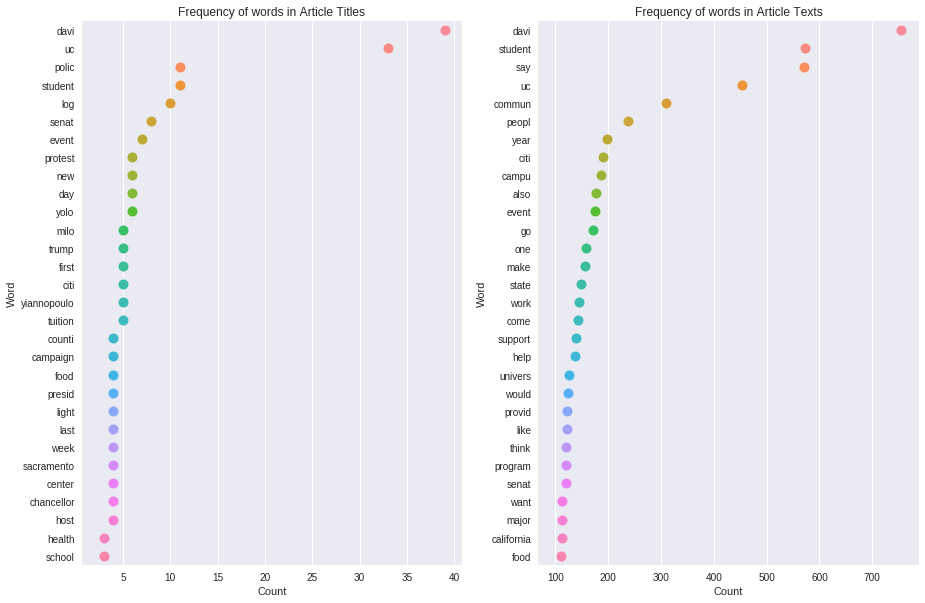

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15,10))
sb.stripplot(x = "Count", y = "Word", size = 10, data = title_count_df, ax = axes[0])
sb.stripplot(x = "Count", y = "Word", size = 10, data = text_count_df, ax = axes[1])
axes[0].set_title("Frequency of words in Article Titles")
axes[1].set_title("Frequency of words in Article Texts")

### Cosine Similiarty

In [19]:
tfidf = TfidfVectorizer(tokenizer=stem_text, stop_words='english', smooth_idf = True, norm = None)

In [20]:
tfs_camp = tfidf.fit_transform(campus_news_df['text'])
tfs_city = tfidf.fit_transform(city_news_df['text'])

In [21]:
camp_mean = np.mean(tfs_camp.toarray())
city_mean = np.mean(tfs_city.toarray())

### Mean Similarity between Campus News and City News

In [22]:
camp_mean, city_mean

(35.464017727151926, 32.191658975362124)

### Some conclusion
#### What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* Based on the 120 articles scraped, the Aggie seems to have a tendency to cover campus related news/topics most of the time, for example, campus events, UC board news, student senate related news, police logs etc. Words like 'davis', 'student', 'polic', 'event', and 'senate' are occurs quite frequently. It is no surprise such words have tendency to show up in articles posted by the Aggie since it's a news outlet about the city of davis and its community. 


* From the mean value of the cosine similarity measure done on both campus and city articles, they appear to have somewhat similar topics. Their values do not have a huge difference. I would say since davis is a "university"  base city, it's reasonable to find news articles between city and campus have little difference and share similarity.

<hr style="height:2px;border:none;color:#333;" />

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

In [23]:
#helper function to get top n pairs from cosine similiarity matrix
def get_top_cossim(cos_score, n ):
    """
    Get top N highest value from the cosine similiarty matrix
    
    Argument: 
        cos_score: the cosine similarity matrix (numpy array)
        n: highest n many values (int)
    """
    high_score_idx = []
    for i in cos_score.argsort():
        high_score_idx.append(i[-2])
    
    high_score_val = []
    for i in high_score_idx:
        for j in range(cos_score.shape[0]):
            high_score_val.append(cos_score[j][i])
    
    return sorted(zip(high_score_val,range(cos_score.shape[0]), high_score_idx), reverse = True)[:n]

In [24]:
tfs_tot = tfidf.fit_transform(news_df['text'])

#similiarty score
cos_score = cosine_similarity(tfs_tot.toarray())
cos_score

array([[ 1.        ,  0.98655805,  0.98857711, ...,  0.98440187,
         0.98260245,  0.99206594],
       [ 0.98655805,  1.        ,  0.98869722, ...,  0.99075786,
         0.99129441,  0.98881101],
       [ 0.98857711,  0.98869722,  1.        , ...,  0.98662362,
         0.98770244,  0.99363584],
       ..., 
       [ 0.98440187,  0.99075786,  0.98662362, ...,  1.        ,
         0.9866014 ,  0.98713522],
       [ 0.98260245,  0.99129441,  0.98770244, ...,  0.9866014 ,
         1.        ,  0.9926331 ],
       [ 0.99206594,  0.98881101,  0.99363584, ...,  0.98713522,
         0.9926331 ,  1.        ]])

In [25]:
get_top_cossim(cos_score,10)

[(1.0000000000000004, 41, 0),
 (0.99709761217762516, 0, 41),
 (0.99655580914964192, 38, 42),
 (0.99500381145590955, 6, 110),
 (0.99493980253003433, 73, 23),
 (0.99380276996499084, 51, 38),
 (0.9935602715237386, 75, 0),
 (0.99298499771924187, 99, 110),
 (0.99296961178450482, 42, 38),
 (0.99291075670721007, 37, 6)]

<b>From the above results, it seems like article 0 and 41 are extremely similar when compared in both ways, runner-ups are article 38 and 42, and 6 and 110</b>

In [26]:
#helper function to get common words between 2 articles

def find_common_words(text1, text2):
    set1 = set(stem_text([text1], True))
    set2 = set(stem_text([text2], True))
    
    return len(set1 & set2), set1 & set2

In [27]:
#1st pair words in common
print find_common_words(news_df['text'].ix[41], news_df['text'].ix[0])

(35, set([u'help', u'approv', u'continu', u'critic', u'interim', u'opportun', u'impact', u'educ', u'commun', u'univers', u'ralph', u'research', u'current', u'state', u'davi', u'valu', u'new', u'leader', u'faculti', u'may', u'chancellor', u'initi', u'nation', u'california', u'believ', u'student', u'becom', u'hexter', u'last', u'provid', u'say', u'presid', u'academ', u'campu', u'uc']))


In [28]:
#2nd pair words in common
print find_common_words(news_df['text'].ix[38], news_df['text'].ix[42])

(41, set([u'continu', u'say', u'want', u'need', u'opportun', u'pursu', u'napolitano', u'safeti', u'would', u'polici', u'media', u'support', u'univers', u'research', u'also', u'state', u'program', u'includ', u'across', u'janet', u'chancellor', u'gener', u'june', u'california', u'plan', u'student', u'educ', u'davi', u'center', u'possibl', u'provid', u'could', u'request', u'focu', u'order', u'stand', u'presid', u'meet', u'studi', u'campu', u'uc']))


In [29]:
#3rd pair words in common
print find_common_words(news_df['text'].ix[6], news_df['text'].ix[110])

(37, set([u'one', u'protest', u'dakota', u'reserv', u'involv', u'scale', u'leak', u'make', u'access', u'also', u'state', u'hold', u'complet', u'pipelin', u'north', u'potenti', u'peopl', u'missouri', u'water', u'california', u'month', u'demonstr', u'land', u'organ', u'corpor', u'could', u'say', u'surround', u'indigen', u'american', u'environ', u'stand', u'clean', u'rock', u'countri', u'river', u'treati']))


### Some Conclusion

#### What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?


* Titles of top 3 pairs of most similar articles 

    1st pair: 
        Interim Chancellor Hexter, UC leaders sign letter to urge action against climate change
    
        UC President selects Gary May as new UC Davis chancellor

    2nd pair: 
        Napolitano to reinforce tentative plans to expand UC Davis into Sacramento
    
        California schools press Donald Trump to continue DACA as president
    
    3rd pair: 
        UC Davis students participate in UC-wide #NoDAPL day of action
    
        Water is sacred, water is life
        
* Common words between each pair shown

    1st pair:
    
    - 35 words in common 
     
    - academ','approv','becom','believ','california','campu','chancellor','commun','continu','critic', 'current','davi','educ','faculti', 'help', 'hexter','impact','initi','interim','last', 'leader','may','nation','new','opportun','presid','provid','ralph','research','say','state','student','uc', 'univers','valu'

 2nd pair:
 
 - 41 words in common
 
 - u'continu', u'say', u'want', u'need', u'opportun', u'pursu', u'napolitano', u'safeti', u'would', u'polici', u'media', u'support', u'univers', u'research', u'also', u'state', u'program', u'includ', u'across', u'janet', u'chancellor', u'gener', u'june', u'california', u'plan', u'student', u'educ', u'davi', u'center', u'possibl', u'provid', u'could', u'request', u'focu', u'order', u'stand', u'presid', u'meet', u'studi', u'campu', u'uc'
 
 3rd pair:
 
 - 37 words in common
 
 - 'one', 'protest', 'dakota', 'reserv', 'involv', 'scale', 'leak', 'make', 'access', 'also', 'state', 'hold', 'complet', 'pipelin', 'north', 'potenti', 'peopl', 'missouri', 'water', 'california', 'month', 'demonstr', 'land', 'organ', 'corpor', 'could', 'say', 'surround', u'indigen', 'american', 'environ', 'stand', 'clean', 'rock', 'countri', 'river', 'treati'


* It seems like the amount of words shared in common does not necessarily lead to high similarity value. This might be because the common words' occurrence vary from pair to pair, some pair may have less common words but the occurrences of such words are high, and vice versa

<hr style="height:2px;border:none;color:#333;" />

#### Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

* In my opinion, I don't think this corpus alone is representative of the Aggie. First, due to the limited data, there are only 120 articles in our corpus, and out of those, only the news section was obtained. I would consider this corpus as a sample of the "big picture". Also, I don't believe discarding other sections such as sports and arts will represent the Aggie's diversity in terms of topics. Since the Aggie covers mostly about students' life and the community in the city of Davis, as a student myself, I'm very interested and love to know what's happening in other sections, not just news. Hence, I think it's not very representative.


* This corpus covers timeline from Late Feburary (now) up to Early November of 2016. If one is interested in looking at news coverage after the 2016 presidential election or wants to know the aftermath of a university community's reaction to the election, this corpus will do a fair job supporting such topics. Other inferences that this corpus might support can be related to activaties during winter break, a majority of students are not local citizens here in Davis, so it's interesting to find out what's happening in Davis during the winter break and holidays